In [60]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [61]:
experiment_type = 'reward-network-iii-6A-v2'
experiment_type = 'reward-network-iii-6B-v1'
experiment_type = 'reward-network-iii-7B-v1'
experiment_type = 'reward-network-iii-8B-v1'
experiment_type = 'reward-network-iii-8A-v1'
experiment_type = 'sim_3states_8r_v1'
player_df = pd.read_csv(os.path.join('./data/pilots/',experiment_type,'player.csv'))

In [62]:
min_player_score = player_df['player_score'].min()
max_player_score = player_df['player_score'].max()

# define plt color map
cmap = plt.cm.get_cmap('viridis')
# define color range
cnorm = plt.Normalize(vmin=min_player_score, vmax=max_player_score)
# map score to a color
cpick = plt.cm.ScalarMappable(norm=cnorm, cmap=cmap)

/tmp/ipykernel_370939/3372780949.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


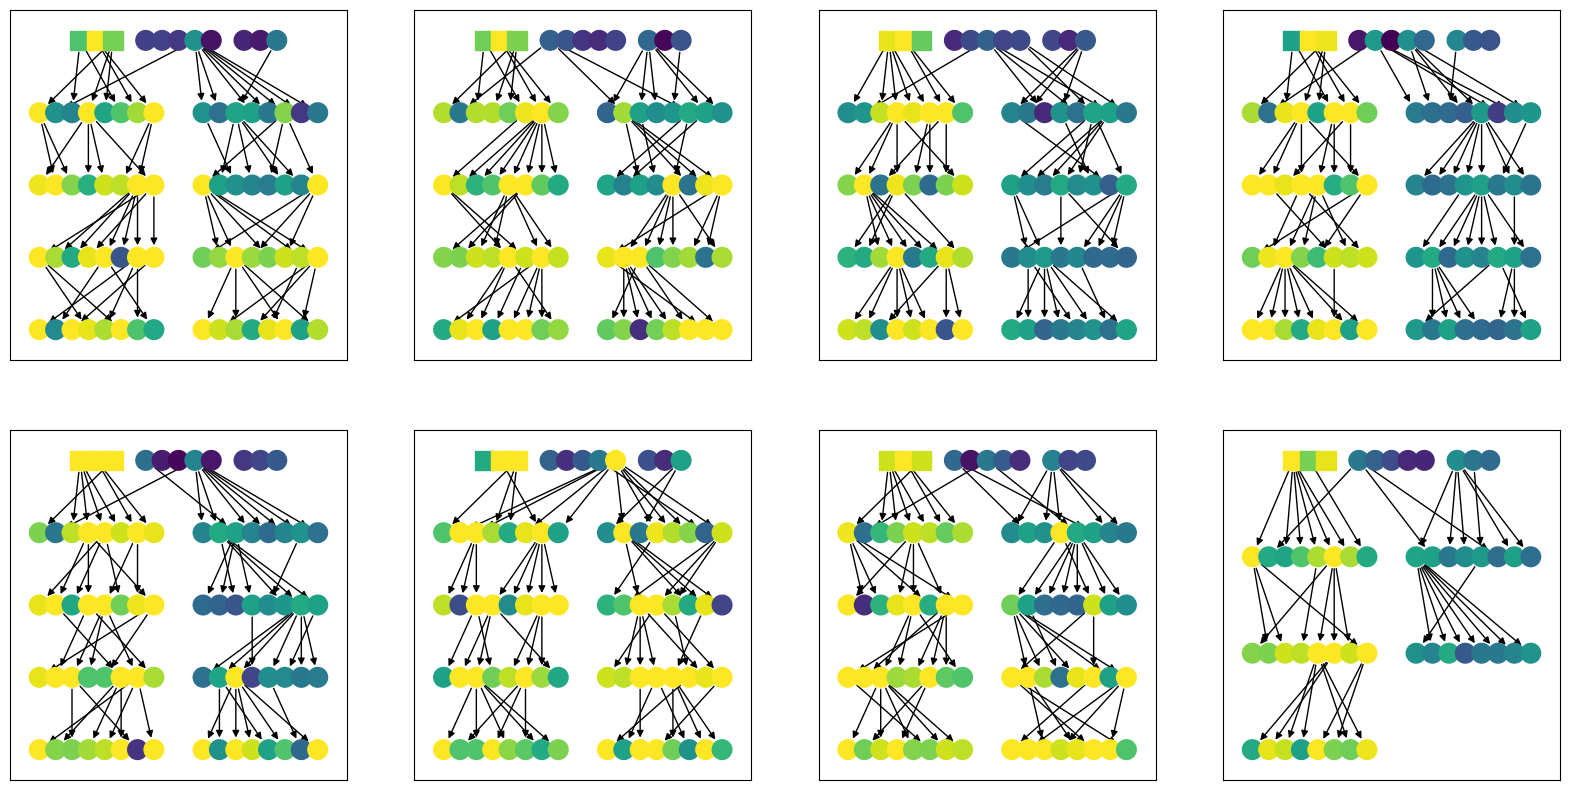

In [63]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



# Create a dictionary to store node colors, positions, and labels
node_colors = {}
node_positions = {}
node_labels = {}
node_shapes = {}
node_size = 200

player_df = player_df[player_df['replication_idx'] < 8]

n_gen = player_df['generation'].max() + 1
max_per_gen = player_df['within_generation_idx'].max() + 1
n_ai = player_df.groupby(['replication_idx'])['ai_player'].sum().max()

n_reps = player_df['replication_idx'].max() + 1
# create subplots with 4 columns and matching number of rows
cols = min(4, n_reps)
rows = (n_reps-1) // cols + 1
fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))


# Iterate through the DataFrame
for rep_idx, rep_df in player_df.groupby('replication_idx'):
    # Create a directed graph
    G = nx.DiGraph()
    # set the current axis
    if rows ==1 and cols == 1:
        ax = axs
    elif rows == 1:
        ax = axs[rep_idx % cols]
    elif cols == 1:
        ax = axs[rep_idx // cols]
    else:
        ax = axs[rep_idx // cols, rep_idx % cols]
    for idx, player in rep_df.iterrows():
        session_id = str(player['session_id'])
        # Add nodes
        G.add_node(session_id, label=player['session_name'])
        # Assign color
        node_colors[session_id] = mcolors.to_hex(cpick.to_rgba(player['player_score']))
        # Assign position
        x_shift = (max_per_gen-(max_per_gen//2 + n_ai)) / 2 if player['generation'] == 0 else 0
        x_shift += 0 if player['condition'] == 'w_ai' else (2 if player['condition'] == 'wo_ai' else 1)
        # x_shift = 0
        y_shift = n_gen
        node_positions[session_id] = ((player['within_generation_idx'] + x_shift), (y_shift - player['generation']))
        # Add labels
        node_labels[session_id] = player['session_name']
        # Assign shapes
        node_shapes[session_id] = 's' if player['ai_player'] else 'o'


        # Add edges
        if not pd.isna(player['advisor']):
            advisor_id = str(player['advisor'])
            G.add_edge(advisor_id, str(player['session_id']))
            if advisor_id not in node_colors:
                # Assign a default color if advisor_id is not in player_df
                node_colors[advisor_id] = 'gray'

    # Generate a list of colors for each node in the graph
    final_node_colors = [node_colors[node] for node in G.nodes()]

    # Draw the network
    for shape in set(node_shapes.values()):
        # Filter nodes by shape
        filtered_nodes = [node for node in G.nodes() if node_shapes[node] == shape]
        nx.draw_networkx_nodes(G, node_positions, nodelist=filtered_nodes, 
                            node_color=[node_colors[node] for node in filtered_nodes],
                            node_shape=shape, node_size=node_size, ax=ax)
    nx.draw_networkx_edges(G, node_positions, edge_color='black', ax=ax)
    # nx.draw_networkx_labels(G, node_positions, labels=node_labels)

plt.show()

    